In [63]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Cleaning

make sampling even

1. reduce the dataset by sampling a smaller size (35515 rows), even distribution of categories
2. min-max scale the features to account for different ranges in data like BMI
3. add an intercept bias term to features
4. split into training/test data

In [64]:
df = pd.read_csv('../archive/diabetes_012_health_indicators_BRFSS2015.csv')

# columns should be type int -- none are float or categorical
df = df.astype(int)

# reduce dataset by sampling 
sample_size = 0.3
random_state = 1

df_small = df.sample(frac=0.2, random_state=1)
df_small.shape

(50736, 22)

In [65]:
# get the features
df_feat = df_small.drop("Diabetes_012", axis=1)
df_feat.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
235899,1,0,1,23,1,0,0,1,1,1,...,1,0,2,0,0,0,0,13,6,6
74852,0,0,1,22,1,0,1,1,1,1,...,1,0,2,0,5,0,1,9,6,8
8205,1,1,1,26,1,0,0,1,1,1,...,1,0,2,0,0,0,0,11,4,6
127632,1,0,1,39,0,0,0,1,1,1,...,1,0,4,0,0,0,1,11,6,5
32021,0,0,1,22,1,0,0,0,1,1,...,1,0,1,0,0,0,0,10,6,8


In [66]:
def getTrainTestData(df, test_size=0.2):
    """
    Splits the data into train and test sets.
    """

    # Split the data into features and target
    X = df.drop("Diabetes_012", axis=1)
    y = df["Diabetes_012"].to_numpy()


    # min max scaling, rounded to 3 decimal places
    scaler = MinMaxScaler()
    X_scale = scaler.fit_transform(X).round(3)
    # Add a new column filled with ones -- for intercept/bias term
    X_scale = np.hstack((X_scale,np.ones([X_scale.shape[0],1], X_scale.dtype)))

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

In [73]:
X_train_small, X_test_small, y_train_small, y_test_small = getTrainTestData(df_small, test_size=0.2)
X_train_big, X_test_big, y_train_big, y_test_big = getTrainTestData(df, test_size=0.2)

# MLP

## sklearn

- ~45 seconds to fit: 300 iterations, 1 hidden layer size 100

Loss function

ADAM:
- 0.837, hidden = (100,)
- 0.847, hidden = (50,)
- 0.848 , hidden = (15,)
- 0.841, hidden = (50,20)
- 0.846, hidden = (20,10,)
- 0.848, hidden = (20), batch_size=50 --> 20 seconds to train also

WITH BALANCED DATASET: 2 classes
- .74

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [75]:
clf = MLPClassifier(
    random_state=1, 
    max_iter=300,
    batch_size=50,
    hidden_layer_sizes=(20),
    learning_rate='invscaling',
                    ).fit(X_train_small, y_train_small)

In [76]:
clf.predict_proba(X_test[:1])
clf.predict(X_test[:5, :])
clf.score(X_test, y_test)

0.8554394954670871

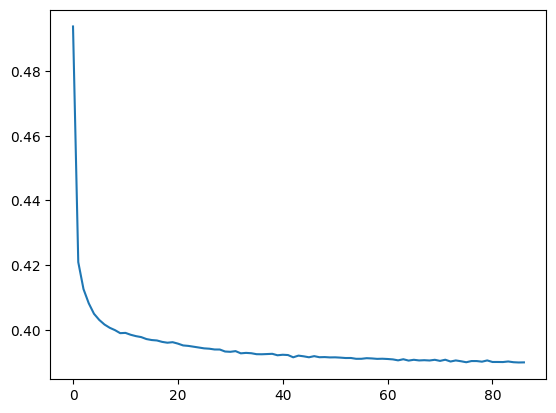

In [77]:
# plot the loss curve
plt.plot(clf.loss_curve_)

In [ ]:
print(clf.predict_proba(X_test[:1]))
print(clf.predict(X_test[:5, :]))
print(clf.score(X_test, y_test))

In [13]:
clf.classes_

array([0, 1, 2])

In [14]:
clf.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 20,
 'learning_rate': 'invscaling',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 300,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

## only two classes

using sri's balanced dataset that only has diabetes or not diabetes (no pre-diabetes).

This generally performs worse than the distinction between 2 classes. I'm thinking this may be because ppl with diabetes and pre-diabetes are similar in lifestyle, so when they are changed from pre to no diabetes, then the classifier wants to call them diabetes. This should be looked into more.

In [17]:
balanced_df = pd.read_csv("../balanced_diabetes_data.csv")

In [18]:
# then split into training and test datasets
y = balanced_df.loc[:,"Diabetes_012"].to_numpy()
df_feat = balanced_df.drop("Diabetes_012", axis=1)

# min max scaling, rounded to 3 decimal places
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(df_feat).round(3)

# Add a new column filled with ones -- for intercept/bias term
X_scale = np.hstack((X_scale,np.ones([X_scale.shape[0],1], X_scale.dtype)))
X_scale

[X_train_2, X_test_2, y_train_2, y_test_2] = train_test_split(X_scale, y, test_size = .3)

# we would then train the model on the training set
X_train_2, y_train_2

(array([[0.   , 0.   , 1.   , ..., 1.   , 0.714, 1.   ],
        [1.   , 1.   , 1.   , ..., 0.8  , 0.714, 1.   ],
        [0.   , 0.   , 1.   , ..., 0.6  , 0.429, 1.   ],
        ...,
        [1.   , 1.   , 1.   , ..., 0.2  , 0.   , 1.   ],
        [1.   , 1.   , 1.   , ..., 0.8  , 0.   , 1.   ],
        [1.   , 1.   , 1.   , ..., 0.6  , 0.   , 1.   ]]),
 array([0, 1, 0, ..., 1, 0, 0]))

In [19]:
clf = MLPClassifier(
    random_state=1, 
    max_iter=300,
    hidden_layer_sizes=(20),
    learning_rate='invscaling',
                    ).fit(X_train_2, y_train_2)

print(clf.predict_proba(X_test_2[:1]))
print(clf.predict(X_test_2[:5, :]))
print(clf.score(X_test_2, y_test_2))

[[0.11552667 0.88447333]]
[1 0 1 0 0]
0.7471708789136176


## keras


---
Accuracy: 0.8488273024559021

model = keras.Sequential([
    Dense(20, activation='relu', input_shape=(22,)),
    Dense(3, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train_p, epochs=10, batch_size=32)

---

In [ ]:
# keras contains the tensorflow package, often used for fitting NNets
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD
from keras.losses import binary_crossentropy


from tensorflow import keras
from tensorflow.keras.layers import Dense

2025-04-07 11:08:09.404627: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
y_train_p = keras.utils.to_categorical(y_train_small, num_classes=3)
y_test_p = keras.utils.to_categorical(y_test_small, num_classes=3)

model = keras.Sequential([
    Dense(20, activation='relu', input_shape=(22,)),
    Dense(3, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_small, y_train_p, epochs=7, batch_size=32, verbose=1)
loss, accuracy = model.evaluate(X_test_small, y_test_p)
# predictions = model.predict(new_data)
accuracy

Epoch 1/7


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1269/1269 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8361 - loss: 0.4740
Epoch 2/7
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step - accuracy: 0.8410 - loss: 0.4139
Epoch 3/7
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step - accuracy: 0.8433 - loss: 0.4102
Epoch 4/7
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 1s 947us/step - accuracy: 0.8459 - loss: 0.3991
Epoch 5/7
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step - accuracy: 0.8485 - loss: 0.3982
Epoch 6/7
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step - accuracy: 0.8430 - loss: 0.4022
Epoch 7/7
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8472 - loss: 0.3981
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.8590 - loss: 0.3772


0.8537642955780029

# Scale to larger dataset

In [82]:
y_train_p = keras.utils.to_categorical(y_train_big, num_classes=3)
y_test_p = keras.utils.to_categorical(y_test_big, num_classes=3)

model = keras.Sequential([
    Dense(20, activation='relu', input_shape=(22,)),
    Dense(3, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_big, y_train_p, epochs=4, batch_size=50, verbose=1)
loss, accuracy = model.evaluate(X_test_big, y_test_p)
# predictions = model.predict(new_data)
accuracy

Epoch 1/4
4059/4059 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8392 - loss: 0.4487
Epoch 2/4
4059/4059 ━━━━━━━━━━━━━━━━━━━━ 4s 957us/step - accuracy: 0.8452 - loss: 0.4046
Epoch 3/4
4059/4059 ━━━━━━━━━━━━━━━━━━━━ 4s 898us/step - accuracy: 0.8472 - loss: 0.3996
Epoch 4/4
4059/4059 ━━━━━━━━━━━━━━━━━━━━ 4s 913us/step - accuracy: 0.8473 - loss: 0.4004
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - accuracy: 0.8452 - loss: 0.3979


0.8478397727012634